<a href="https://colab.research.google.com/github/Benjamin-morel/TensorFlow/blob/main/04_convolution_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# **Machine Learning Model: Convolutional Neural Network**

| | |
|------|------|
| Filename | 04_convolution_CNN.ipynb |
| Author(s) | Benjamin Morel (benjaminmorel27@gmail.com) |
| Date | September 10, 2024 |
| Aim(s) | Classify images with a simple convolutional neural network |
| Dataset(s) | Flower API Google dataset [[1]](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition) |
| Version | Python 3.10.12 - TensorFlow 2.17.1 |


<br> **!!Read before running!!** <br>
1. Fill in the inputs
2. CPU execution is enough.
3. Run all and read comments.

---

#### **Motivation**

A convolutional neural network (CNN) model is created and trained in this Python script. The objective is to classify 5 different flower classes from the Google API flower dataset.

#### **Outline**
* retrieve data & data augmentation
* CNN model
* training & evaluation
* predictions
* references

---


#### **0. Input section**

The model has already been trained and the user can choose to used a pre-trained model (No) or to repeat the training phase (Yes). Using a pre-trained model saves time, computer resources and CO2 emissions.

In [1]:
training_phase = 'No'

---


#### **1. Python librairies & display utilities [RUN ME]**


In [2]:
from numpy import array, argmax, max
from os import path
from PIL import Image # image processing capabilities
from tensorflow import keras, data, expand_dims, nn
from keras import layers, utils, Sequential, Input, losses, callbacks
from pandas import DataFrame
import matplotlib.pyplot as plt

In [3]:
# import plotting of training curves and pre-trained model

def get_github_files():
  !git clone https://github.com/Benjamin-morel/TensorFlow.git TensorFlow_duplicata # go to the Github repertory TensorFlow and clone it
  training_curves_1 = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/results_graph.jpeg")
  training_curves_2 = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/results_graph_OF.jpeg")
  model = keras.models.load_model('TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/04_convolution_CNN.h5')
  !rm -rf TensorFlow_duplicata/ # delete the cloned repertory
  return training_curves_1, training_curves_2, model

In [4]:
# import flower examples taken from Google Image

def get_github_photo():
  !git clone https://github.com/Benjamin-morel/TensorFlow.git TensorFlow_duplicata # go to the Github repertory TensorFlow and clone it
  tulip = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/tulip.jpeg") # see section 3
  rose = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/rose.jpeg") # see section 3
  daisy = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/daisy.jpeg") # see section 3
  sunflowers = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/sunflowers.jpeg") # see section 3
  bouquet = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/bouquet.jpeg") # see section 3
  bouquet_2 = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/bouquet_2.jpeg") # see section 3
  !rm -rf TensorFlow_duplicata/ # delete the cloned repertory
  return tulip, rose, daisy, sunflowers, bouquet, bouquet_2

In [5]:
# plot an image with the label as title

def plot_images(image, *label):
  plt.imshow(image)
  plt.title("%s" %label)
  image = plt.axis("off")
  return image

In [6]:
# plot the loss/accuracy values obtained from one dataset at each epoch

def plot_evolution(history):
  loss_train, loss_val = history[0], history[2]
  acc_train, acc_val = history[1], history[3]
  epochs = range(1, len(acc_train) + 1)

  fig = plt.subplot(2,1,1)
  plt.plot(epochs, loss_train, label='Training', color='blue')
  plt.plot(epochs, loss_val, label='Validation', color='orange')
  plt.legend(loc='best', fontsize=10)
  plt.grid(True, linestyle='--', alpha=0.6), plt.ylabel('Loss', fontsize=12)

  plt.subplot(2,1,2)
  plt.plot(epochs, acc_train, color='blue')
  plt.plot(epochs, acc_val, color='orange')
  plt.xlabel('Epochs', fontsize=12), plt.ylabel('Accuracy', fontsize=12)
  plt.grid(True, linestyle='--', alpha=0.6)

---


#### **2. Retrieve data and batch generation**

###### **2.1. Retrieve data**

The flower Google API dataset is composed of 3,670 photos of flowers labelled in 5 classes: rose, dandelion, tulip, sunflower and daisy.

In [7]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = utils.get_file('flower_photos', dataset_url, untar=True)
data_dir = path.join(path.dirname(data_dir), 'flower_photos')

###### **2.2. Batch generation**

The original dataset is split into 3 sets: the training set (80%), validation set (16%) and test set (4%).



In [8]:
batch_size, img_height, img_width = 32, 180, 180
train_ds = utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="training", seed=123, image_size=(img_height, img_width), batch_size=batch_size)
val_ds = utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="validation", seed=123, image_size=(img_height, img_width), batch_size=batch_size)

class_names = train_ds.class_names

val_ds_batch = data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_ds_batch // 5) # create a test set from 20% of the validation set
val_ds = val_ds.skip(val_ds_batch // 5)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
print("# of training batches: %d" %data.experimental.cardinality(train_ds), "\n# of test batches: %d" %data.experimental.cardinality(test_ds), "\n# of validation batches: %d" %data.experimental.cardinality(val_ds))

# of training batches: 92 
# of test batches: 4 
# of validation batches: 19


###### **2.3. Data inspection**

The function `plot_image` is used to inspect the flower dataset. Elements of this database are very varied and rather noisy (presence of decorative elements, human, grave...).

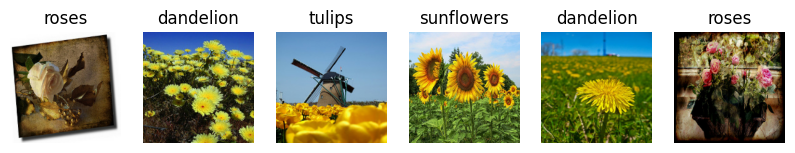

In [10]:
plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):
  tensor_images, tensor_labels = images, labels
  for i in range(6):
    ax = plt.subplot(1, 6, i + 1)
    plot_images(images[i].numpy().astype("uint8"), class_names[labels[i]])

###### **2.4. Performance data configuration**

The following section is used to store data temporarily in the RAM (`cache` function) and to load the next batch in background with a prefetch buffer size computed by AUTOTUNE (`prefetch` function).

In [11]:
AUTOTUNE = data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

---


#### **3. Model and training**

###### **3.1. Data augmentation**

During initial training, the low number of training sample resulted in over-fitting. The graph in section 3.4 shows a poor generalization of performance. Realistic transformations (rotation, flip & zoom) are then applied to the training data to diversify the data set.

In [12]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.1)(x)
outputs = layers.RandomZoom(0.1)(x)

data_augmentation = keras.Model(inputs=inputs, outputs=outputs, name="data_augmentation_layer")

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

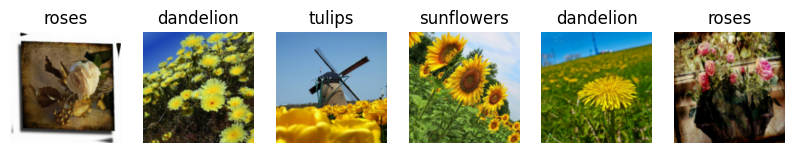

In [13]:
plt.figure(figsize=(10, 8))
images_modified = data_augmentation(tensor_images) # apply to the example set
for i in range(6):
  ax = plt.subplot(1, 6, i + 1)
  plot_images(images_modified[i].numpy().astype("uint8"), class_names[tensor_labels[i]])

###### **3.2. Model definition**

The model is composed of a series of convolution/pooling layers to extract features/patterns from the input data. A classical neural network is then implemented to compute logit scores in output.

* `Input` & `Rescaling` layers:
  * **Inputs & Outputs:** a 3D tensor (`img_height`, `img_width`, `3`)

* First `Conv2D` layer:
  * **Outputs:** (`img_height`, `img_width`, `filters`)
  * **Comments:** `padding = 'same'` so the size of images processed is preserved

* First `MaxPooling2D` layer:
  * **Outputs:** (`img_height/2`, `img_width/2`, `filters`)
  * **Comments:** the maximum 2x2 value is retained

* ...

The number of filters at each convolution layer is doubled, starting initially at 16, a good compromise between model complexity and performance. Considering this number of filters, the complexity of the model - the number of parameters - is minimal for 5 `Conv2D`/`MaxPooling2D` layers.

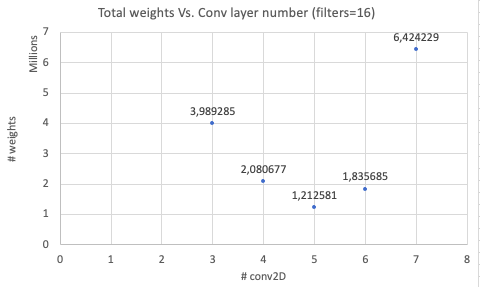

In [14]:
def create_model():
  num_classes = len(class_names)

  inputs = keras.Input(shape=(img_height, img_width, 3))
  x = layers.Rescaling(1./255)(inputs)
  x = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  outputs = layers.Dense(num_classes)(x)

  model = keras.Model(inputs=inputs, outputs=outputs, name="classifier_CNN")

  model.compile(optimizer='adam',
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[keras.metrics.SparseCategoricalAccuracy()])
  return model

###### **3.3. Model training**

The file is saved in .h5 format without the optimizer parameters, as the model can reach a very large number of parameters and therefore generate a large save file. The .h5 format without optimizer parameters requires the model to be recompiled once loaded.

In [15]:
def train_model(model, training_data, validation_data, **kwargs):
  kwargs.setdefault("epochs", 5)
  kwargs.setdefault("verbose", 1)
  log = model.fit(training_data, validation_data=validation_data, validation_freq=1, callbacks=[stop_early], **kwargs)

  return log.history["loss"], log.history["sparse_categorical_accuracy"], log.history["val_loss"], log.history["val_sparse_categorical_accuracy"]

In [16]:
model = create_model()
epochs = 20

if training_phase == "Yes":
  stop_early = callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5, restore_best_weights=True, min_delta=0.001)
  classifier_accuracy = train_model(model, train_ds, val_ds, epochs=epochs)
  model.save('04_convolution_CNN.h5', include_optimizer=False) # save file with .h5 format and without optimizer parameters
  print("Accuracy max %0.1f %% reached at the epoch %d" %(100*max(classifier_accuracy[3]), argmax(classifier_accuracy[3])+1))
else:
  training_curves, training_curves_overfitting, model = get_github_files()
  model.compile(optimizer='adam',                                                   # recompilation of the loaded model
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[keras.metrics.SparseCategoricalAccuracy()])

Cloning into 'TensorFlow_duplicata'...
remote: Enumerating objects: 472, done.
remote: Counting objects: 100% (278/278), done.
remote: Compressing objects: 100% (190/190), done.
remote: Total 472 (delta 195), reused 88 (delta 88), pack-reused 194 (from 2)
Receiving objects: 100% (472/472), 96.10 MiB | 16.02 MiB/s, done.
Resolving deltas: 100% (235/235), done.


###### **3.4. Model evaluation and comments**

A training phase without data augmentation and dropout layer was carried out beforehand and is shown on the training curve plot (right side). The use of data augmentation and layer dropout eliminated the error of overfitting.

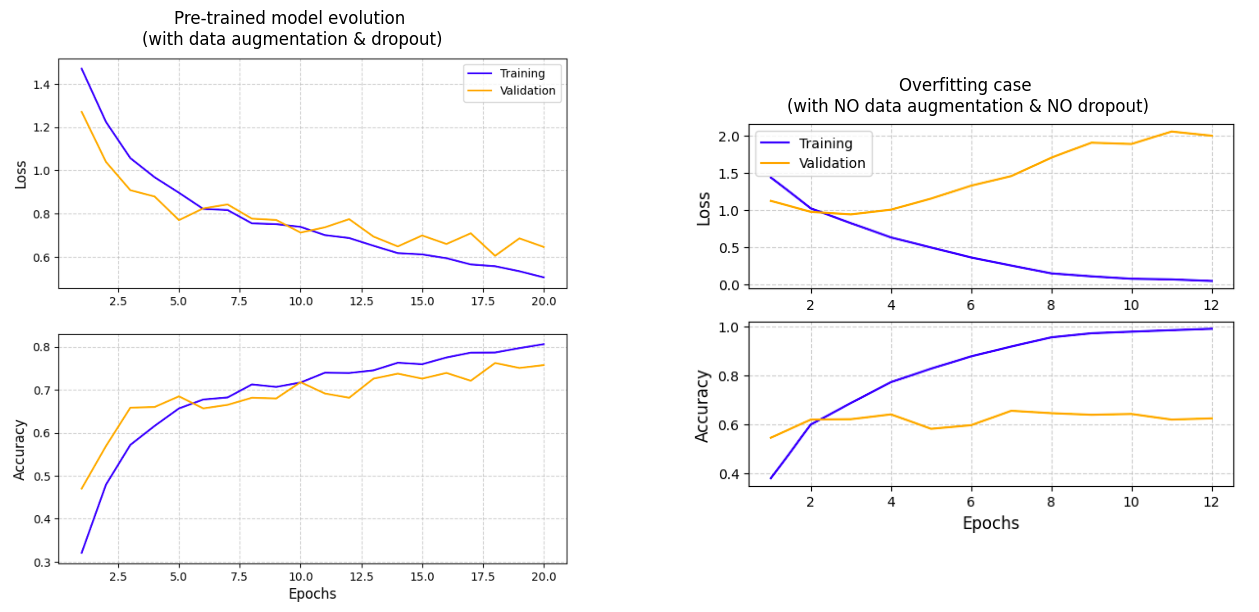

In [17]:
if training_phase == 'Yes':
  plt.figure(figsize=(8, 8))
  plot_evolution(classifier_accuracy)
else:
  plt.figure(figsize=(16, 8))
  plt.subplot(1,2,1)
  plt.imshow(training_curves), plt.title("Pre-trained model evolution \n(with data augmentation & dropout)"), plt.axis("off")
  plt.subplot(1,2,2)
  plt.imshow(training_curves_overfitting), plt.title("Overfitting case \n(with NO data augmentation & NO dropout)"), plt.axis("off")
  plt.show()

In [18]:
loss_test, accuracy_test = model.evaluate(test_ds, verbose=0)
print("Test loss function value %0.1f and test accuracy value %0.1f %%" %(loss_test, 100*accuracy_test))

Test loss function value 0.8 and test accuracy value 71.1 %


---


#### **4. Predictions**

The model can be used to make predictions for flower photos found on Google Image. The softmax function is used to transform the logit scores output by the model into probabilities. 3 out of 4 are correctly recognized.

In [19]:
tulip, rose, daisy, sunflowers, bouquet, bouquet_2 = get_github_photo()

Cloning into 'TensorFlow_duplicata'...
remote: Enumerating objects: 472, done.
remote: Counting objects: 100% (278/278), done.
remote: Compressing objects: 100% (190/190), done.
remote: Total 472 (delta 195), reused 88 (delta 88), pack-reused 194 (from 2)
Receiving objects: 100% (472/472), 96.10 MiB | 18.15 MiB/s, done.
Resolving deltas: 100% (235/235), done.


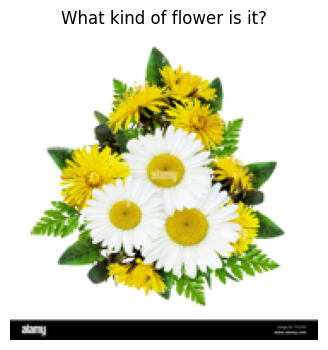

In [20]:
img = bouquet_2
img = Image.fromarray(array(img))
resized_img = img.resize((img_height, img_width))
plt.figure(figsize=(4, 4))
plt.imshow(resized_img), plt.title("What kind of flower is it?"), plt.axis("off")
plt.show()

In [21]:
resized_img_array = expand_dims(array(resized_img), 0)
predictions = model.predict(resized_img_array)
score = nn.softmax(predictions[0])

df = DataFrame(data={'class_names': class_names, 'score': 100*score.numpy()})
print(df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
  class_names      score
0       daisy  99.056503
1   dandelion   0.263386
2       roses   0.095919
3  sunflowers   0.568891
4      tulips   0.015291


The model is also tested on bouquet photos comprising 2 types of flowers. The model's predictions are not as expected: the score is very high for a single type of flower in the bouquet, but the model doesn't seem able to identify any other type of flower.

**The accuracy of the test set - 70% - and the failure to identify 2 flower types on the same photo, the complexity of the task demands a more robust model, extracting more complex and numerous features.**

---


#### **5. References**


| | | | | |
|------|------|------|------|------|
| Index | Title | Author(s) | Type | Comments |
|[[1]](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition) | Flowers Recognition | Alexander Mamaev | dataset | - |
|[[2]](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks) | Convolutional Neural Networks cheatsheet | Afshine Amidi and Shervine Amidi | lecture | - |
|[[3]](https://www.tensorflow.org/tutorials/images/cnn) | Convolutional Neural Network (CNN) | TensorFlow | Tutoriels | - |
|[[4]](https://www.tensorflow.org/tutorials/images/data_augmentation) | Data augmentation | TensorFlow | Tutoriels | - |
|[[5]](https://cs231n.github.io/) | Convolutional Neural Networks for Visual Recognition | Stanford cs231n | lecture | - |